In [1]:
!pip install matplotlib --quiet
!pip install livelossplot --quiet
!pip install nltk --quiet
#mc cp s3/tordjx ummt/Core*model*files --recursive
# watch -n 0.5 nvidia-smi
import nltk
nltk.download('wordnet')
image_bool = False
load_model = False


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\valen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#%%
from Modele_decodeur_maison import *
from Pipeline import *
from Trainer import * 
from greedy_beam_search import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32

# Texts
tokenized_fr,tokenized_en, vocab_fr,vocab_en = get_train_data_nouveau(batch_size,True)
tokenized_val_fr,tokenized_val_en, _,_ = get_train_data_nouveau(batch_size,False)
#Data non batchés
n_token_fr = len(vocab_fr.keys())
n_token_en = len(vocab_en.keys())

inv_map_en = {v: k for k, v in vocab_en.items()}
inv_map_fr = {v: k for k, v in vocab_fr.items()}

n_head =8
num_encoder_layers = 2
num_decoder_layers = 2
dim_feedforward = 512
dropout = 0.3
activation = nn.Softmax(dim=2)
embedding_dim = 128

model_fr = Modèle(n_token_fr,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_fr["TOKEN_VIDE"],vocab_fr["DEBUT_DE_PHRASE"],vocab_fr["FIN_DE_PHRASE"]).to(device)
model_en = Modèle(n_token_en,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_en["TOKEN_VIDE"],vocab_en["DEBUT_DE_PHRASE"],vocab_en["FIN_DE_PHRASE"]).to(device)

if load_model : 
    model_en.load_state_dict(torch.load("tordjx/model_en"))
    model_fr.load_state_dict(torch.load("tordjx/model_fr"))
else : 
    with open("logs.txt",'w') as logs :
        logs.write("")
        logs.close()
if image_bool :
    train_features  = np.load("tordjx/train-resnet50-res4frelu.npy")
    val_features = np.load("tordjx/val-resnet50-res4frelu.npy")
    train_features = torch.from_numpy(train_features)
    val_features = torch.from_numpy(val_features)
    train_data_fr = [tokenized_fr, train_features]
    train_data_en = [tokenized_en, train_features]
    val_data_fr = [tokenized_val_fr, val_features]
    val_data_en = [tokenized_val_en, val_features]


d:\Programmes\Python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


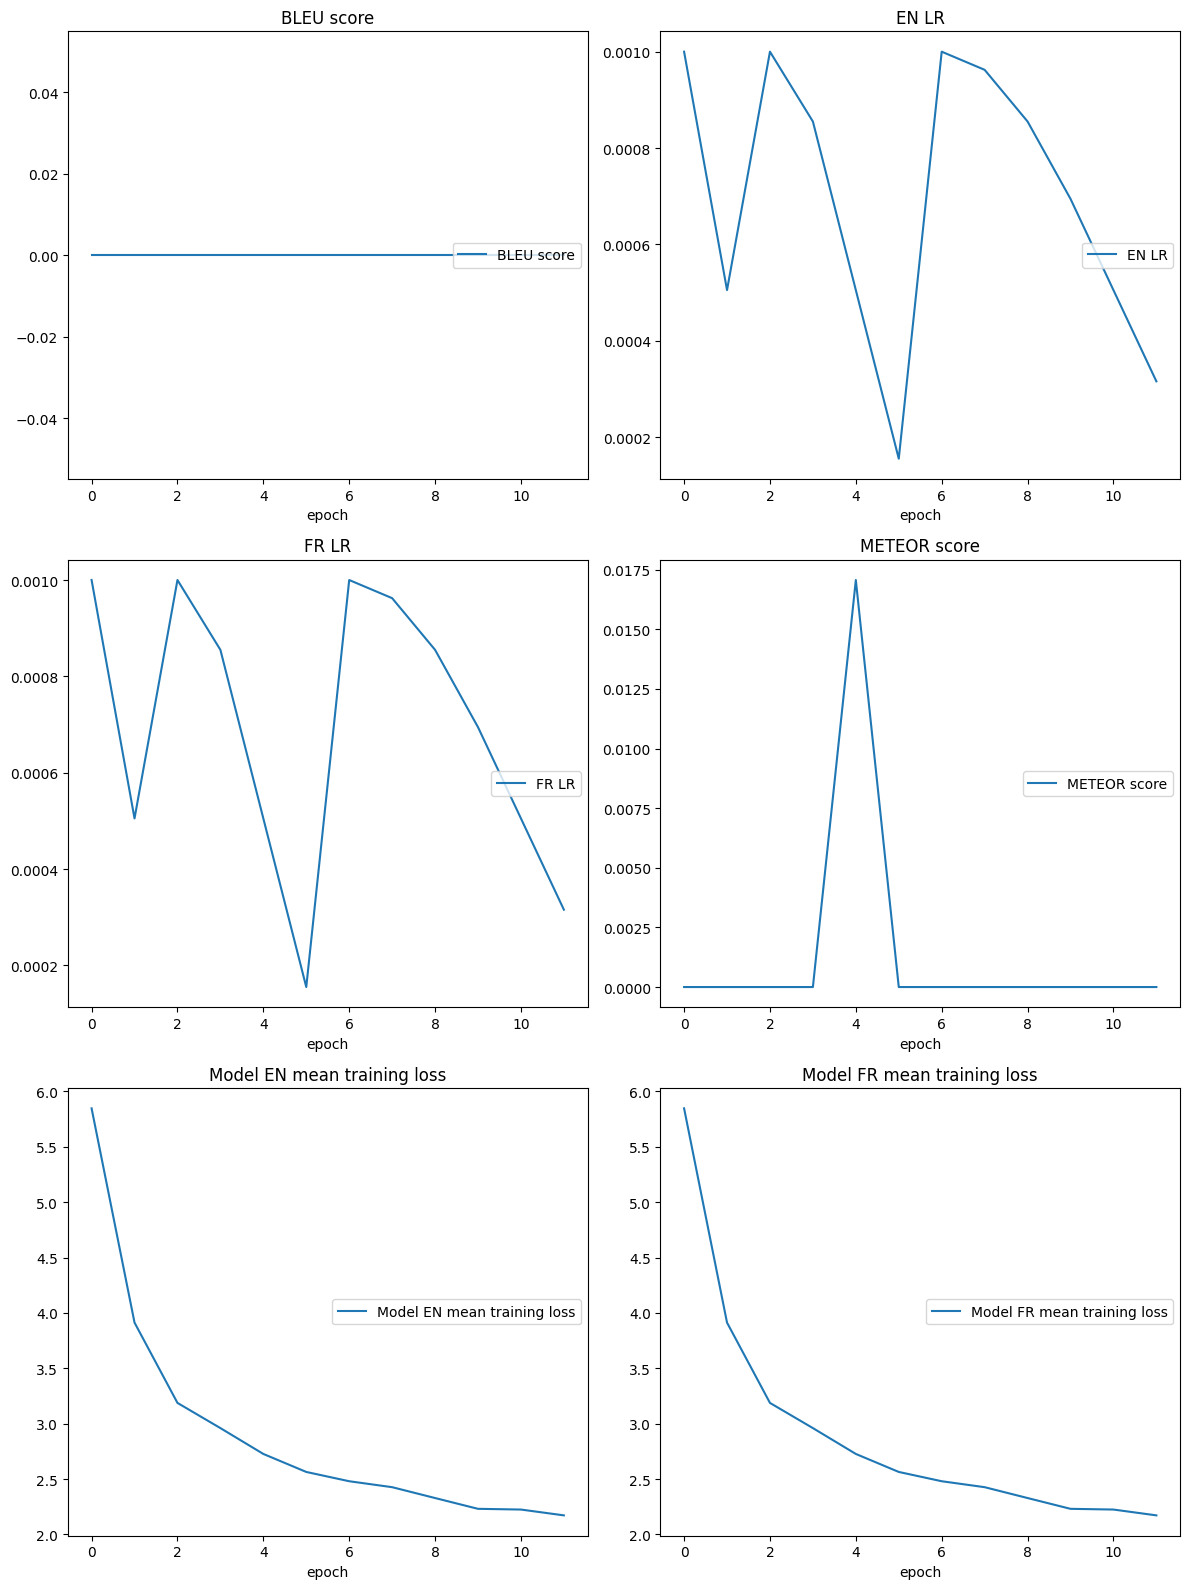

BLEU score
	BLEU score       	 (min:    0.000, max:    0.000, cur:    0.000)
EN LR
	EN LR            	 (min:    0.000, max:    0.001, cur:    0.000)
FR LR
	FR LR            	 (min:    0.000, max:    0.001, cur:    0.000)
METEOR score
	METEOR score     	 (min:    0.000, max:    0.017, cur:    0.000)
Model EN mean training loss
	Model EN mean training loss 	 (min:    2.172, max:    5.846, cur:    2.172)
Model FR mean training loss
	Model FR mean training loss 	 (min:    2.172, max:    5.846, cur:    2.172)


In [3]:
# model_en.curr_epoch = 4 
# model_fr.curr_epoch = 4 
if image_bool :
    mixed_train(val_data_en,val_data_fr,inv_map_en,inv_map_fr,model_fr,model_en,train_data_fr,train_data_en,150,batch_size, True,1/2)
else :
    mixed_train(tokenized_val_en,tokenized_val_fr,inv_map_en,inv_map_fr,model_fr,model_en,tokenized_fr,tokenized_en,150,batch_size, False,1/2)


In [ ]:
def moving_average(a, n=1,tail = 0) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    
    return (ret[n - 1:] / n)[tail:]

plt.plot(moving_average(model_fr.loss_list))
plt.plot(moving_average(model_en.loss_list))
print(len(model_fr.loss_list)/(29000/batch_size))


In [ ]:
torch.save(model_fr.state_dict(), "tordjx/model_fr")
torch.save(model_en.state_dict(), "tordjx/model_en")
import os
import s3fs
!pip install pandas
import pandas
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})
fs.upload("tordjx/model_fr","tordjx/model_fr")
fs.upload("tordjx/model_en","tordjx/model_en")

In [ ]:
tokenized_val_en = val_data_en[0]
i = np.random.randint(len(tokenized_val_en)//batch_size)
j = np.random.randint(batch_size)
src,features,tgt = donne_random(i,j,val_data_en,val_data_fr,batch_size,True)
features = features.to(device,dtype=torch.float32)
data = [src,features]
# OUT= traduit('greedy',model_en,model_fr,data, inv_map_en,True,tgt[j],inv_map_fr,j)
OUT = greedy_beam_search.CCF_greedy(model_en,model_fr,src, features, True)
values,indices = torch.topk(OUT,2,2)
print(values)
print(indices)